<a href="https://colab.research.google.com/github/shailaptl/Sari/blob/main/Sari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from fastai.vision import *

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

In [ ]:
!pip3 install torchvision

In [ ]:
!pip3 install Cython

In [ ]:
from google_images_download import google_images_download
response = google_images_download.googleimagesdownload()
arguments = {"keywords":"Mirror Work Fabric","limit":100,"offset":0,"print_urls":False}
paths = response.download(arguments)

In [ ]:
from PIL import Image, ImageEnhance
import os
path = r"/content/drive/My Drive/sari_images"
for folder in os.listdir(path):
    num = 1
    pathOfCategory = path + "/" + folder
    for imgfile in os.listdir(pathOfCategory):
        im = Image.open(pathOfCategory +"/"+ imgfile)
        im = im.convert("RGB")
        width, height = im.size
        edgeLength = min(width, height)
        im = im.crop((0, 0, edgeLength, edgeLength))
        im = im.resize((500, 500))
        im.save(pathOfCategory +"/"+ str(num) + ".jpg")
        os.remove(pathOfCategory +"/"+ imgfile)

        num = num + 1
        enhancer = ImageEnhance.Contrast(im)
        enhanced_im = enhancer.enhance(3.0)
        enhanced_im.save(newPath +"/"+ str(num) + ".jpg")

        num = num + 1
        enhancer = ImageEnhance.Color(im)
        enhanced_im = enhancer.enhance(.55)
        enhanced_im.save(newPath +"/"+ str(num) + ".jpg")
        
        num = num + 1
        transposed  = im.transpose(Image.ROTATE_90)
        transposed.save(newPath +"/"+ str(num) + ".jpg")

        num = num + 1

CNN- Convolutional Neural Network

In [ ]:
import os
print( os.getcwd())
DATA_PATH = "/content/drive/My Drive/sari_images"
bs = 6
n_epochs = 10

# import zipfile
# zip_ref = zipfile.ZipFile("/sari_images.zip", 'r')
# zip_ref.extractall()
# zip_ref.close()

/content


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

def train(model, criterion, optim, n_epochs):
    
    # will use these for plotting
    train_losses = []
    train_accuracy = []
    
    val_losses = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
#         lr_schedule.step()
        # Each epoch has a training phase and a validation phase
        ### training phase ###########################################
        
        model.train()
        train_running_loss = 0.0
        train_running_corrects = 0
        
        # iterate data
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero parameter gradients
            optim.zero_grad()
            
            # forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # backprop
                loss.backward()
                optim.step()
                
            train_running_loss += loss.item() * inputs.size(0)
            train_running_corrects += torch.sum(preds == labels.data)
        ###############################################################
            
        ### validation phase ##########################################
        model.eval() # does stuff like turn off dropout layers
        
        test_running_loss = 0.0
        test_running_corrects = 0
        
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optim.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
            test_running_loss += loss.item() * inputs.size(0)
            test_running_corrects += torch.sum(preds == labels.data)
        #################################################################
         # collect statistics
        train_epoch_loss = train_running_loss/len(train_loader.dataset)
        train_epoch_acc  = train_running_corrects.double()/len(train_loader.dataset)
        
        test_epoch_loss = test_running_loss/len(test_loader.dataset)
        test_epoch_acc  = test_running_corrects.double()/len(test_loader.dataset)
        
        train_losses.append(train_epoch_loss)
        train_accuracy.append(train_epoch_acc)
        
        val_losses.append(test_epoch_loss)
        val_accuracy.append(float(test_epoch_acc))
        
        
        # print some stats
        print('')
        print('Epoch %d'%epoch)
        # print('Train:\tLoss: {:.3f}\tAcc: {:.3f}'.format(train_epoch_loss, train_epoch_acc))
        # print('Test :\tLoss: {:.3f}\tAcc: {:.3f}'.format(test_epoch_loss, test_epoch_acc))
        
    torch.save(model.state_dict(), './saved_model.pt')
        
    return train_losses, train_accuracy, val_losses, val_accuracy

In [ ]:
import matplotlib.pyplot as plt

tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=tfms)

train_sz = .8
train_sz_num = int(len(dataset)*train_sz)
test_sz_num = len(dataset)-train_sz_num
train_data, test_data = torch.utils.data.random_split(dataset, (train_sz_num,test_sz_num))

b_sizes = [1, 2, 4, 8, 16, 32]
val_accuracies = []

for bs in b_sizes:
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=False)

  model = models.resnet18(pretrained=True)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 5) # specifies final layer
  model = model.to(device) # sends to gpu if you have one for speed
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  train_losses, train_accuracy, val_losses, val_accuracy = train(model, criterion, optimizer, n_epochs)
  val_accuracies.append(val_accuracy)

In [ ]:
torch.save(model, "/content/drive/My Drive/cnn_v2")

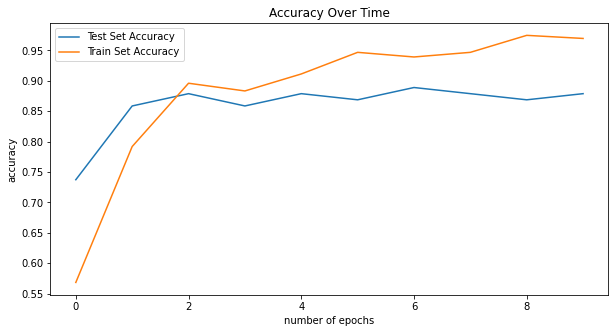

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Accuracy Over Time")
plt.plot(val_accuracy,label="Test Set Accuracy")
plt.plot(train_accuracy,label="Train Set Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

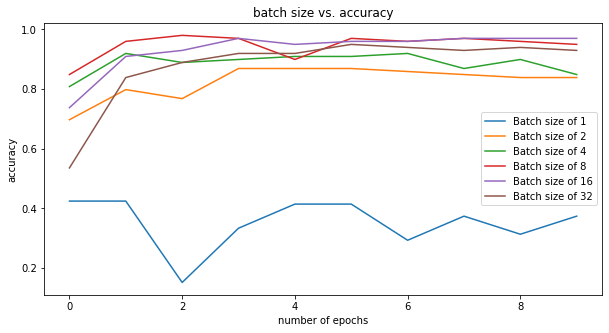

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("batch size vs. accuracy")

for w in range(0,6):
  plt.plot(val_accuracies[w], label="Batch size of " + str(b_sizes[w]))

plt.xlabel("number of epochs") #b_sizes = [1, 2, 4, 8, 16, 32]
plt.ylabel("accuracy")
plt.legend()
plt.show()

GAN- Generative Adversarial Network

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 998
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  998


In [ ]:
# Root directory for dataset
dataroot = DATA_PATH

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 300

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

cuda:0


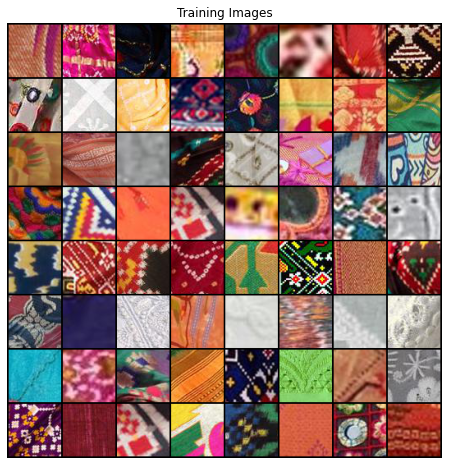

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                              #  transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
print(device)

cuda:0


In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) 
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
  # Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
Discr_True = []
Discr_False = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        Discr_True.append(D_x)
        Discr_False.append(D_G_z1)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/300][0/4]	Loss_D: 1.5932	Loss_G: 5.2310	D(x): 0.7032	D(G(z)): 0.5236 / 0.0084
[1/300][0/4]	Loss_D: 0.6454	Loss_G: 7.7791	D(x): 0.8339	D(G(z)): 0.3229 / 0.0007
[2/300][0/4]	Loss_D: 0.7227	Loss_G: 9.9661	D(x): 0.8565	D(G(z)): 0.3831 / 0.0001
[3/300][0/4]	Loss_D: 0.9794	Loss_G: 13.7659	D(x): 0.8886	D(G(z)): 0.5243 / 0.0000
[4/300][0/4]	Loss_D: 0.5162	Loss_G: 11.7033	D(x): 0.8889	D(G(z)): 0.2796 / 0.0000
[5/300][0/4]	Loss_D: 0.4654	Loss_G: 14.3606	D(x): 0.8610	D(G(z)): 0.2346 / 0.0000
[6/300][0/4]	Loss_D: 0.1192	Loss_G: 13.4813	D(x): 0.8932	D(G(z)): 0.0000 / 0.0000
[7/300][0/4]	Loss_D: 5.0372	Loss_G: 22.8234	D(x): 0.9423	D(G(z)): 0.9903 / 0.0000
[8/300][0/4]	Loss_D: 0.5399	Loss_G: 14.0745	D(x): 0.9647	D(G(z)): 0.3679 / 0.0000
[9/300][0/4]	Loss_D: 0.7138	Loss_G: 26.7869	D(x): 0.5380	D(G(z)): 0.0000 / 0.0000
[10/300][0/4]	Loss_D: 0.4272	Loss_G: 12.8501	D(x): 0.9833	D(G(z)): 0.3009 / 0.0000
[11/300][0/4]	Loss_D: 0.3086	Loss_G: 12.3877	D(x): 0.9079	D(G(z)): 0.1788 

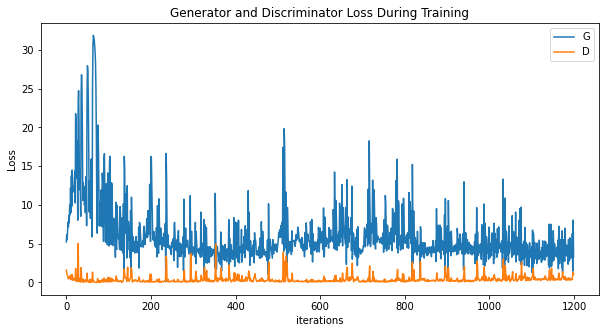

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

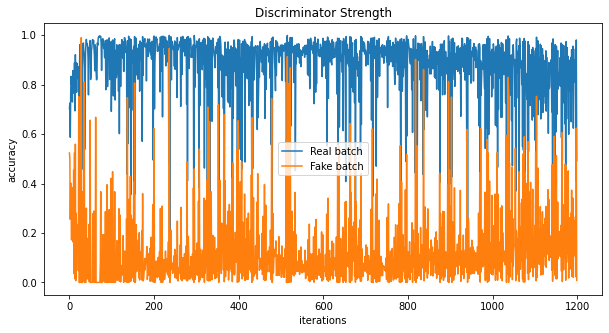

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Strength")
plt.plot(Discr_True,label="Real batch")
plt.plot(Discr_False,label="Fake batch")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.show()

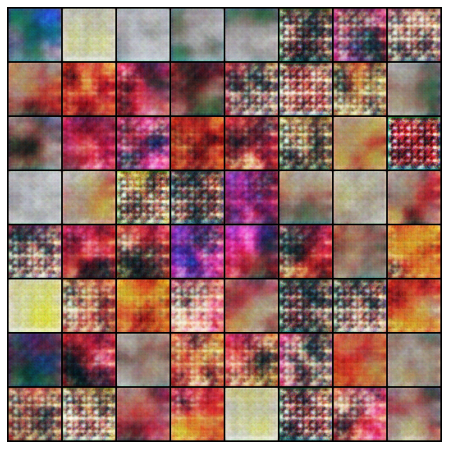

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

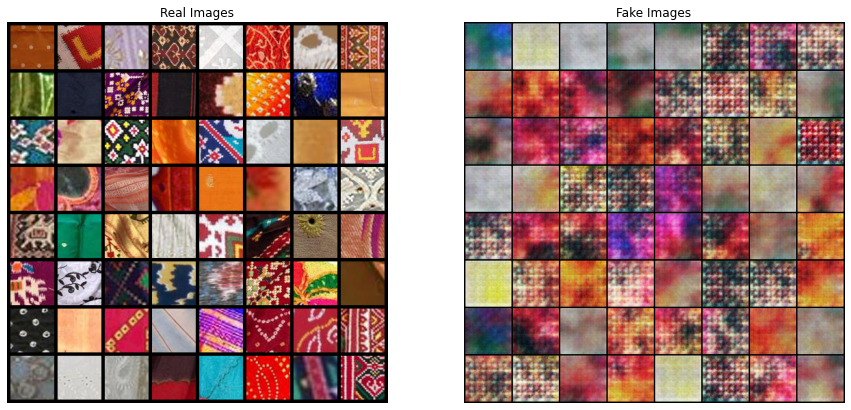

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()